<CENTER>
</br>
<p><font size="5">  M2MO - XVA Analysis  </font></p>
<p><font size="5">  Project - Gap Risk </font></p>
<p><font size="4">  SANGLIER Nathan & PÉCHEUL Ronan </font></p>
<p><font size="3"></br>March 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr, ronan.pecheul@ensae.fr</span>
</p>
</CENTER>

----------------------------

In this project, we focus on computing numerically the CVA of a portfolio made of a unique interest rate swap. We assume the underlying rate process follows Black-Scholes dynamics. First, we derive analytical formulas for the CVA without RIM. We also compute this quantity using linear (neural network) regression and nested Monte-Carlo simulations. We then compute the CVA for a portfolio of one call option using polynomial regression, non-linear neural network regression, and nested Monte-Carlo simulations. The results are validated with the twin Monte-Carlo method. In a second part, we follow the same steps for the CVA with RIM.

## <span style="color:#00B8DE"> 0 - Imports & Parameters </span>

In [1]:
import  torch
import  torch.nn                as      nn
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm
from    sklearn.linear_model    import  LinearRegression
from    sklearn.preprocessing   import  PolynomialFeatures
from    tqdm                    import  tqdm

In [2]:
r       = 0.02
S0      = 100
kappa   = 0.12
sigma   = 0.2
h       = 0.25
T       = 5
delta   = 1/52
gamma   = 0.1

def beta(t):
    return np.exp(-r*t)

In [3]:
dt                      = delta
time_grid               = np.arange(0, T+dt, dt)
N                       = len(time_grid)-1
swap_grid               = np.arange(0, T+h, h)
d                       = len(swap_grid)-1

map_time_to_swap_inds   = np.searchsorted(swap_grid, time_grid, side='right') # l_{t} for t in time_grid
map_swap_to_time_inds   = np.where(np.isin(time_grid, swap_grid))[0] # indices of T_{l} in time_grid

Sbar                    = S0 * np.sum(beta(swap_grid[1:]) * np.exp(kappa*swap_grid[:-1])) / np.sum(beta(swap_grid[1:]))  
nom                     = 10**4 * beta(swap_grid[0]) / np.sum(beta(swap_grid[1:]))

M                       = 50000

In [4]:
def gen_S(M):
    '''Generate M paths of the underlying asset price'''
    paths       = np.zeros((M, N+1))
    paths[:, 0] = S0
    Z           = np.random.normal(0, 1, size=(M, N))
    for i in range(1, N+1):
        paths[:, i] = paths[:, i-1] * np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*Z[:, i-1])
    return paths

def gen_MtM_swap(S_paths):
    '''Generate paths of the MtM swap process based on the underlying asset price paths'''
    M   = S_paths.shape[0]
    MtM = np.zeros((M, N+1))
    for i in range(N):
        lt          = map_time_to_swap_inds[i]
        part_sum    = np.sum(beta(swap_grid[lt+1:])*(np.exp(kappa*(swap_grid[lt:-1] - time_grid[i]))*S_paths[:, i].reshape(-1, 1) - Sbar), axis=1)
        MtM[:, i]   = h*nom/beta(time_grid[i]) * (beta(swap_grid[lt])*(S_paths[:, map_swap_to_time_inds[lt-1]] - Sbar) + part_sum)
    return MtM

S_paths         = gen_S(M)
MtM_swap_paths  = gen_MtM_swap(S_paths)

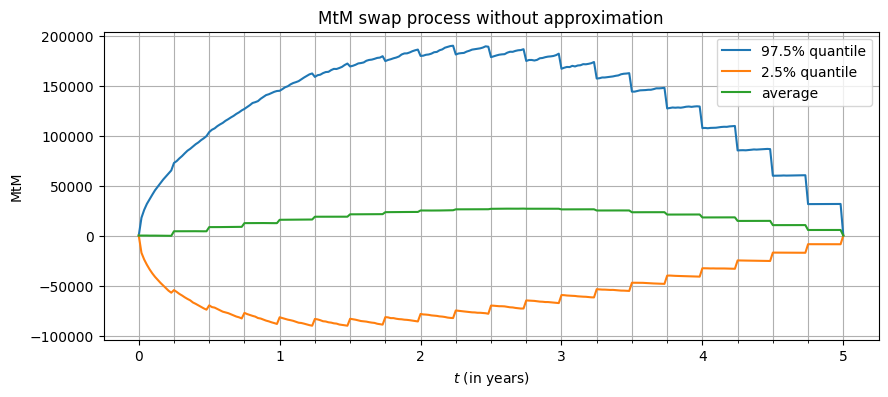

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, np.quantile(MtM_swap_paths, 0.975, axis=0), label='97.5% quantile')
ax.plot(time_grid, np.quantile(MtM_swap_paths, 0.025, axis=0), label='2.5% quantile')
ax.plot(time_grid, np.mean(MtM_swap_paths, axis=0), label='average')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('MtM')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('MtM swap process without approximation')
ax.legend()
plt.show()

## <span style="color:#00B8DE"> I - CVA without RIM </span>

### 1) Interest rate swap </span>

#### Question 1. </span>

#### Question 2. </span>

We define $\forall t < T$:
$$
\begin{align*}
    \text{MtM Gap}_{t^\delta}
    &= \left(\beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t \text{MtM}_t\right)^+, \\
    &= \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta} - \hat S_t)^+,
\end{align*}
$$
and $\text{MtM Gap}_{T^\delta} = 0$ (swap has maturity $T$, so no cash flows between $T$ and $T+\delta$). For each pricing time $t \le T$ we want to learn the function $u_t$ st:
$$
u_t(S_t) = \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right].
$$
We know that $u_t = \arg\min_{h \in \mathcal{B}} \mathbb{E}\left[\left(\text{MtM Gap}_{t^\delta}-h(S_t)\right)^2\right]$ and we will approximate this function with a linear regression model and a one layer linear neural network (for each pricing date). Our data consists of $M$ simulated iid samples of $(S_t^{(m)}, \text{MtM Gap}_{t^\delta}^{(m)})$ for each pricing date $t$.

For the linear regression model, we approximate $u_t$ by $\hat u_t^{\text{LR}}(S) = \beta^{\text{LR}}(t) \cdot S$, with $\beta^{\text{LR}}(t)$ being the following OLS estimator:
$$
\begin{align*}
    \beta^{\text{LR}}(t) 
    &= \arg\min_{\beta \in \mathbb{R}} \sum_{m=1}^M \left(\text{MtM Gap}_{t^\delta}^{(m)} - \beta \cdot S_t^{(m)}\right)^2, \\
    &= \frac{\sum_{m=1}^M \text{MtM Gap}_{t^\delta}^{(m)} \cdot S_t^{(m)}}{\sum_{m=1}^M (S_t^{(m)})^2}.
\end{align*}
$$

For the one layer linear neural network, we approximate $u_t$ by $\hat u_t^{\text{NN}}(S) = \beta^{\text{NN}}(t) \cdot S$, with $\beta^{\text{NN}}(t)$ being the following estimator:
$$
\beta^{\text{NN}}(t) \approx \arg\min_{\beta \in \mathbb{R}} \sum_{m=1}^M \left(\text{MtM Gap}_{t^\delta}^{(m)} - h_{\beta}(S_t^{(m)})\right)^2,
$$
where $h_{\theta}$ is the neural network function with parameter $\beta$, and the minimization is done with a gradient descent algorithm.

Notice that we use linear models because we have theoretically the folllowing linear relationship for the swap:
$$
\begin{align}
    \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]
    &= \text{Nom} \cdot A(t) \cdot \hat S_t, \notag \\
    &= \text{Nom} \cdot \beta^{\text{true}}(t) \cdot S_t,
\end{align}
$$
where $\beta^{\text{true}}(t) = \text{Nom} \cdot A(t) \cdot e^{-\kappa t}$.

In [6]:
def f(i):
    if i==N:
        return 0
    else:
        lt_delta = map_time_to_swap_inds[i+1]
        return h * np.sum(beta(swap_grid[lt_delta+1:])*np.exp(kappa*(swap_grid[lt_delta:-1])))

def gen_MtMgap_swap_form(S_paths):
    '''Generates paths of the MtM gap swap process based on the (approximated) formula (2)'''
    MtM_gap = np.zeros_like(S_paths)
    for i in range(N):
        MtM_gap[:, i] = np.maximum(nom*f(i)*(np.exp(-kappa*time_grid[i+1])*S_paths[:, i+1]-np.exp(-kappa*time_grid[i])*S_paths[:, i]), 0)
    return MtM_gap

In [7]:
def A(i):
    return f(i) * (norm.cdf(sigma*np.sqrt(delta)/2) - norm.cdf(-sigma*np.sqrt(delta)/2))

def gen_econd_MtMgap_swap_form(S_paths):
    '''Generates paths of the conditional expectation of the MtM gap swap process based on the formula (4), and the coefficients β(t) describing the linear relationship with S(t)'''
    res         = np.zeros_like(S_paths)
    beta_vals   = np.zeros(N+1)
    for i in range(N):
        beta_vals[i]    = nom * A(i) * np.exp(-kappa*time_grid[i])
        res[:, i]       = beta_vals[i] * S_paths[:, i]
    return beta_vals, res

In [8]:
def calc_CVA(econd_MtMgap_paths):
    'Calculates the CVA based on the estimation of conditional expectation of the MtM gap process'
    CVA_vals = np.trapezoid(econd_MtMgap_paths * np.exp(-gamma*time_grid) * gamma, dx=delta, axis=1)
    return np.mean(CVA_vals)

In [9]:
A_vals                                  = np.array([A(i) for i in range(N+1)])

MtMgap_swap_form_paths                  = gen_MtMgap_swap_form(S_paths)
beta_vals, econd_MtMgap_swap_form_paths = gen_econd_MtMgap_swap_form(S_paths)
CVA_swap                                = nom*S0*np.trapezoid(A_vals * np.exp(-gamma*time_grid) * gamma, dx=delta)

In [10]:
beta_vals_lr = np.zeros(N+1)
for i in range(N+1):
    model = LinearRegression(fit_intercept=False)
    model.fit(S_paths[:, i].reshape(-1, 1), MtMgap_swap_form_paths[:, i])
    beta_vals_lr[i] = model.coef_[0]

econd_MtMgap_swap_lr_paths = beta_vals_lr * S_paths

In [11]:
class LinearRegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)
    def forward(self, x):
        return self.linear(x)

beta_vals_lnn = np.zeros(N+1)
for i in tqdm(range(N+1), desc='Fitting linear regression using neural network'):
    x           = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y           = torch.tensor(MtMgap_swap_form_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model       = LinearRegressionNN()
    criterion   = nn.MSELoss()
    optimizer   = torch.optim.SGD(model.parameters(), lr=0.00001)
    for epoch in range(400):
        model.train()
        optimizer.zero_grad()
        outputs = model(x)
        loss    = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    beta_vals_lnn[i] = model.linear.weight.item()

econd_MtMgap_swap_lnn_paths = beta_vals_lnn * S_paths

Fitting linear regression using neural network: 100%|██████████| 261/261 [06:27<00:00,  1.48s/it]


#### Question 2. </span>

How to validate our results ? First, we can compare $\beta^{LR}$ and $\beta^{NN}$ with $\beta^{true}$ for each pricing date $t$ and see if we get the same values.

MSE beta NN: 1.7181%
MSE beta LR: 1.7181%


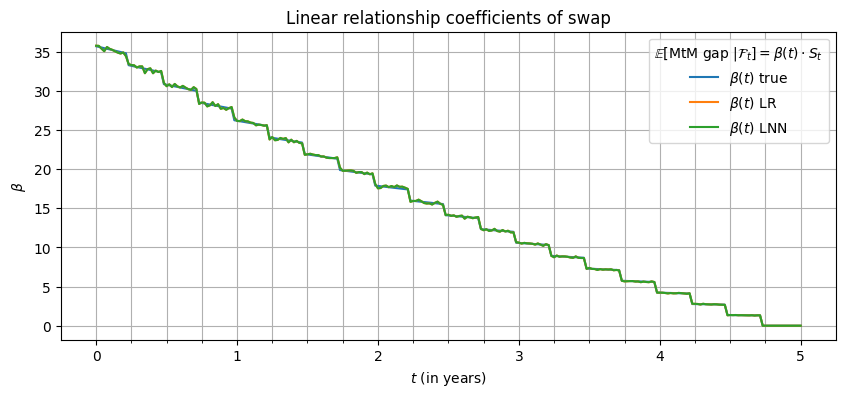

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, beta_vals, label='$\\beta(t)$ true')
ax.plot(time_grid, beta_vals_lr, label='$\\beta(t)$ LR')
ax.plot(time_grid, beta_vals_lnn, label='$\\beta(t)$ LNN')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('$\\beta$')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Linear relationship coefficients of swap')
ax.legend(title='$\\mathbb{E}\\left[\\text{MtM gap } \\vert \\mathcal{F}_t \\right] = \\beta(t) \\cdot S_t$')
print(f"MSE beta NN: {(100*np.mean((beta_vals - beta_vals_lnn)**2)):.4f}%")
print(f"MSE beta LR: {(100*np.mean((beta_vals - beta_vals_lr)**2)):.4f}%")
plt.show()

If we did not had access to the explicit formula of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, we could still validate our results with a twin Monte-Carlo method. Indeed, it can be shown that the regression error at time $t$ is given by:
$$
\mathbb{E}\left[\left(\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right] - \hat u_t(S_t)\right)^2\right]
= \mathbb{E}\left[\hat u_t(S_t)^2 - (\text{MtM Gap}_{t^\delta}^{(1)} + \text{MtM Gap}_{t^\delta}^{(2)}) \cdot \hat u_t(S_t) + \text{MtM Gap}_{t^\delta}^{(1)} \cdot \text{MtM Gap}_{t^\delta}^{(2)}\right],
$$
where $\text{MtM Gap}_{t^\delta}^{(1)}$ and $\text{MtM Gap}_{t^\delta}^{(2)}$ are two iid samples of $\text{MtM Gap}_{t^\delta}$ knowing $S_t$:
$$
\text{MtM Gap}_{t^\delta}^{(1) / (2)} = \text{Nom} \cdot f(t) \cdot (\hat S_{t^\delta}^{(1)/(2)} - \hat S_t)^+,
$$
with $S_{t^\delta}^{(1)/(2)} = S_t e^{(\kappa - \frac{1}{2} \sigma^2) \delta + \sigma \sqrt{\delta} Z^{(1)/(2)}}$.
We can then approximate the regression error with an empirical mean.

In [13]:
def gen_MtMgap_twin_swap_form(S_paths):
    MtM_gap = np.zeros_like(S_paths)
    for i in range(N):
        new_point       = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=M))
        MtM_gap[:, i]   = np.maximum(nom*f(i)*(np.exp(-kappa*time_grid[i+1])*new_point-np.exp(-kappa*time_grid[i])*S_paths[:, i]), 0)
    return MtM_gap

MtMgap_twin_swap_paths_form = gen_MtMgap_twin_swap_form(S_paths)
regerr_swap_twin_lr         = np.mean(econd_MtMgap_swap_lr_paths**2 - (MtMgap_twin_swap_paths_form+MtMgap_swap_form_paths)*econd_MtMgap_swap_lr_paths + MtMgap_twin_swap_paths_form*MtMgap_swap_form_paths, axis=0)
regerr_swap_true_lr         = np.mean((econd_MtMgap_swap_lr_paths - econd_MtMgap_swap_form_paths)**2, axis=0)

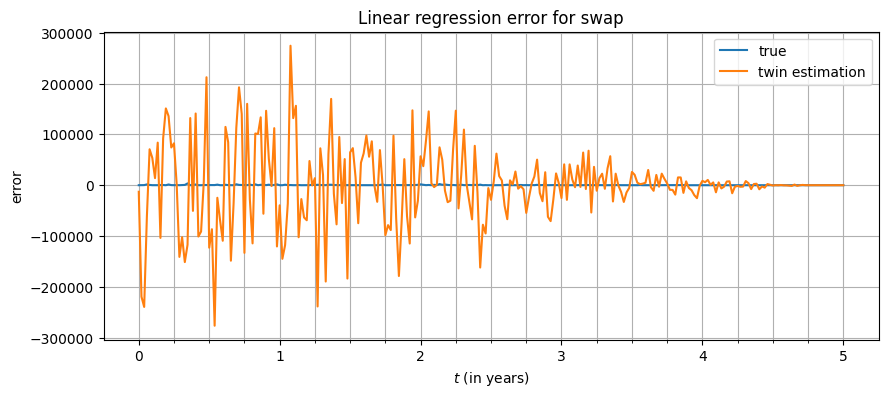

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, regerr_swap_true_lr, label='true')
ax.plot(time_grid, regerr_swap_twin_lr, label='twin estimation')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.legend()
ax.set_title('Linear regression error for swap')
plt.show()

Finally, we can validate our results by comparing them with a nested Monte-Carlo simulation. This apprach only works for validating one trajectory of the approximated $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, ie $\hat u_t(S_t)$, but not for validating the whole function $\hat u_t$. Given a trajectory $(S_t)$, we do the following approximation at each pricing date $t$:
$$
\begin{align*}
\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right] \approx \frac{1}{K} \sum_{k=1}^K \text{MtM Gap}_{t^\delta}^{(k)},
\end{align*}
$$
where $\text{MtM Gap}_{t^\delta}^{(k)}$ are $K$ iid samples of $\text{MtM Gap}_{t^\delta}$ knowing $S_t$, as for the twin Monte-Carlo method. Thus, we chose to generate $K = \sqrt{M}$ new samples of $\text{MtM Gap}_{t^\delta}$ for each pricing date $(t, S_t)$.

In [15]:
def gen_econd_MtMgap_swap_nestedMC(S_paths):
    res = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(int(np.sqrt(M)), len(S_paths))))
        res[:, i]   = np.mean(np.maximum(nom*f(i)*(np.exp(-kappa*time_grid[i+1])*new_points-np.exp(-kappa*time_grid[i])*S_paths[:, i]), 0), axis=0)
    return res

econd_MtMgap_swap_nestedMC_paths = gen_econd_MtMgap_swap_nestedMC(S_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [04:09<00:00,  1.04it/s]


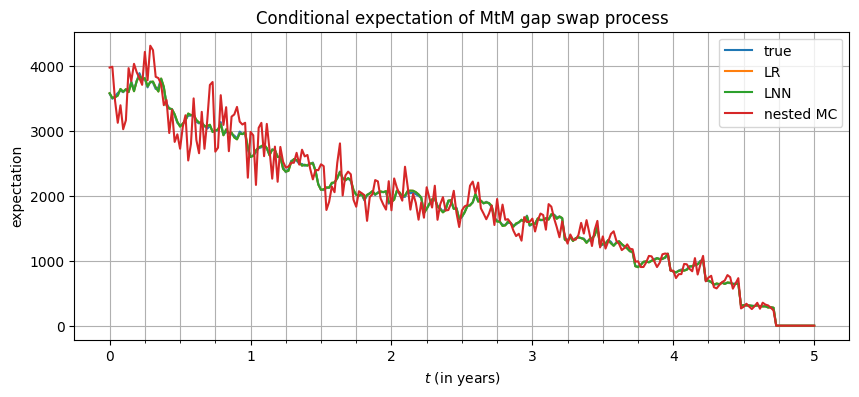

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, econd_MtMgap_swap_form_paths[0], label='true')
ax.plot(time_grid, econd_MtMgap_swap_lr_paths[0], label='LR')
ax.plot(time_grid, econd_MtMgap_swap_lnn_paths[0], label='LNN')
ax.plot(time_grid, econd_MtMgap_swap_nestedMC_paths[0], label='nested MC')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('expectation')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Conditional expectation of MtM gap swap process')
ax.legend()
plt.show()

#### Question 3. </span>

The CVA at time $0$ is given by:
$$
\text{CVA}_0 = \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right] e^{-\gamma t} dt\right].
$$
Thus, the CVA can be computed using our previous estimators $\hat u_t(S_t)$ of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

Notice that we can validate our results using empirical mean for the outer expecation and the formula or nested Monte-Carlo simulation for the inner conditional expectation, but also using the following formula for a swap:
$$
\text{CVA}_0 = \text{Nom} \cdot S_0 \cdot \gamma \cdot \int_0^T A(t) \cdot e^{-\gamma t} dt.
$$

In [17]:
CVA_swap_formMC     = calc_CVA(econd_MtMgap_swap_form_paths)
CVA_swap_lr         = calc_CVA(econd_MtMgap_swap_lr_paths)
CVA_swap_lnn        = calc_CVA(econd_MtMgap_swap_lnn_paths)
CVA_swap_nestedMC   = calc_CVA(econd_MtMgap_swap_nestedMC_paths)

print(f"CVA swap formula: {CVA_swap:.4f}")
print(f"CVA swap using MC for outer expectation and formula for conditional expectation: {CVA_swap_formMC:.4f}")
print(f"CVA swap using MC for outer expectation and LR for conditional expectation: {CVA_swap_lr:.4f}")
print(f"CVA swap using MC for outer expectation and LNN for conditional expectation: {CVA_swap_lnn:.4f}")
print(f"CVA swap using MC for outer expectation and nested MC for conditional expectation: {CVA_swap_nestedMC:.4f}")

CVA swap formula: 807.6319
CVA swap using MC for outer expectation and formula for conditional expectation: 808.0754
CVA swap using MC for outer expectation and LR for conditional expectation: 808.5679
CVA swap using MC for outer expectation and LNN for conditional expectation: 808.5678
CVA swap using MC for outer expectation and nested MC for conditional expectation: 808.0286


### 2) Interest rate call </span>

#### Question 4. </span>

In this question, we consider a portfolio made of an interest rate call option ATM $(K=S_0)$. In this case, we do not have anymore the explicit formulas for calculating $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$ and $\text{CVA}_0$. Moreover,
$$
\text{MtM Gap}_{t^\delta} = \left(\beta_{t^\delta}(\text{MtM}_{t^\delta} + \Delta_{t^\delta}) - \beta_t \text{MtM}_t\right)^+,
$$
and $\text{MtM Gap}_{T^\delta} = 0$, where:
$$
\text{MtM}_t = e^{-r (T-t)} \left(e^{\kappa (T-t)} S_t \mathcal{N}(d_+) - S_0 \mathcal{N}(d_-)\right),
$$
with $d_\pm = \frac{\log(S_t/S_0) + (\kappa \pm \frac{1}{2} \sigma^2)(T-t)}{\sigma \sqrt{T-t}}$.

We do not expect to have a linear relationship between $u_t(S_t) = \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$ and $S_t$ anymore. Thus, we will approximate this function with a polynomial regression model and a non-linear neural network. Our results will be validated with twin Monte-Carlo method and nested Monte-Carlo simulation, as in the previous questions (but loosing analytical formulas).

In [18]:
def gen_MtM_call(S_paths):
    '''Generate paths of the MtM call process based on the underlying asset price paths'''
    M   = S_paths.shape[0]
    MtM = np.zeros((M, N+1))
    for i in range(N):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        MtM[:, i]   = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
    return MtM

def gen_MtMgap_call(MtM_paths):
    '''Generates paths of the MtM gap call process based on definition (1)'''
    return np.maximum(np.diff(beta(time_grid)*MtM_paths, append=0), 0)

MtM_call_paths      = gen_MtM_call(S_paths)
MtMgap_call_paths   = gen_MtMgap_call(MtM_call_paths)

In [19]:
econd_MtMgap_call_pr_paths = np.zeros((M, N+1))
for i in range(N+1):
    model   = LinearRegression(fit_intercept=False)
    poly    = PolynomialFeatures(degree=3, include_bias=True)
    S_poly  = poly.fit_transform(S_paths[:, i].reshape(-1, 1))
    model.fit(S_poly, MtMgap_call_paths[:, i])
    econd_MtMgap_call_pr_paths[:, i] = model.predict(S_poly)

In [20]:
class NonLinearRegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden     = nn.Linear(1, 10)
        self.output     = nn.Linear(10, 1)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

econd_MtMgap_call_nlnn_paths = np.zeros((M, N+1))
for i in tqdm(range(N+1), desc='Fitting non-linear regression using neural network'):
    x           = torch.tensor(S_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    y           = torch.tensor(MtMgap_call_paths[:, i].reshape(-1, 1), dtype=torch.float32)
    model       = NonLinearRegressionNN()
    criterion   = nn.MSELoss()
    optimizer   = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loss  = []
    for epoch in range(400):
        model.train()
        optimizer.zero_grad()
        outputs = model(x)
        loss    = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    econd_MtMgap_call_nlnn_paths[:, i] = model(x).detach().numpy().reshape(-1)

Fitting non-linear regression using neural network: 100%|██████████| 261/261 [09:28<00:00,  2.18s/it]


In [21]:
def gen_MtMgap_twin_call(S_paths):
    MtM_gap = np.zeros_like(S_paths)
    for i in range(N):
        d1              = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2              = d1 - sigma*np.sqrt(T-time_grid[i])
        MtM             = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_point       = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=M))
        new_MtM         = np.exp(-r*(T-time_grid[i+1]))*(new_point*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        MtM_gap[:, i]   = np.maximum(beta(time_grid[i+1])*new_MtM - beta(time_grid[i])*MtM, 0)
    return MtM_gap

MtMgap_twin_call_paths  = gen_MtMgap_twin_call(S_paths)
regerr_call_twin_pr     = np.mean(econd_MtMgap_call_pr_paths**2 - (MtMgap_twin_call_paths+MtMgap_call_paths)*econd_MtMgap_call_pr_paths + MtMgap_twin_call_paths*MtMgap_call_paths, axis=0)

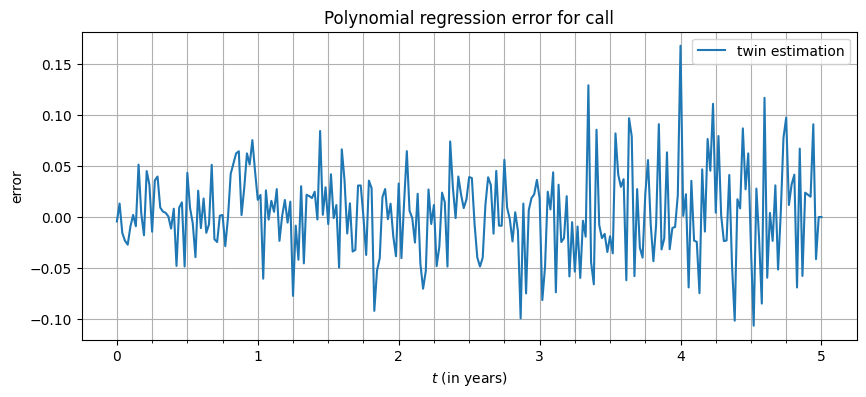

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, regerr_call_twin_pr, label='twin estimation')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('error')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Polynomial regression error for call')
ax.legend()
plt.show()

In [23]:
def gen_econd_MtMgap_call_nestedMC(S_paths):
    res = np.zeros_like(S_paths)
    for i in tqdm(range(N), desc='Processing nested Monte Carlo'):
        d1          = (np.log(S_paths[:, i]/S0) + (kappa + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        MtM         = np.exp(-r*(T-time_grid[i]))*(S_paths[:, i]*np.exp(kappa*(T-time_grid[i]))*norm.cdf(d1) - S0*norm.cdf(d2))
        new_points  = S_paths[:, i]*np.exp((kappa - 0.5*sigma**2)*delta + sigma*np.sqrt(delta)*np.random.normal(0, 1, size=(int(np.sqrt(M)), len(S_paths))))
        new_MtMs    = np.exp(-r*(T-time_grid[i+1]))*(new_points*np.exp(kappa*(T-time_grid[i+1]))*norm.cdf(d1) - S0*norm.cdf(d2))
        res[:, i]   = np.mean(np.maximum(beta(time_grid[i+1])*new_MtMs - beta(time_grid[i])*MtM, 0), axis=0)
    return res

econd_MtMgap_call_nestedMC_paths = gen_econd_MtMgap_call_nestedMC(S_paths)

Processing nested Monte Carlo: 100%|██████████| 260/260 [02:48<00:00,  1.54it/s]


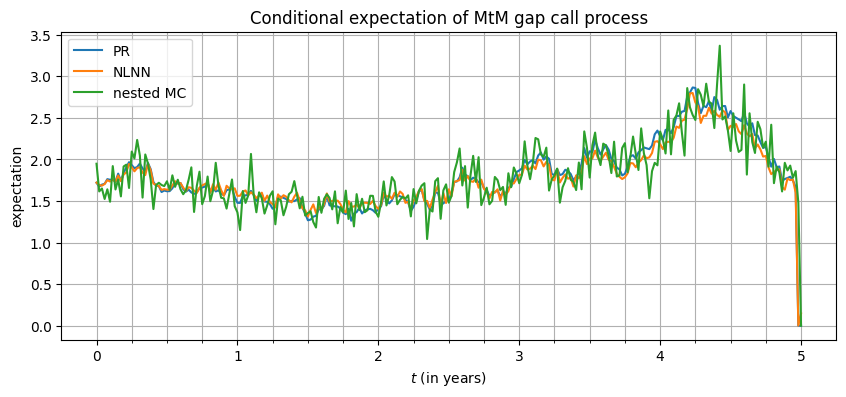

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_grid, econd_MtMgap_call_pr_paths[0], label='PR')
ax.plot(time_grid, econd_MtMgap_call_nlnn_paths[0], label='NLNN')
ax.plot(time_grid, econd_MtMgap_call_nestedMC_paths[0], label='nested MC')
ax.set_xlabel('$t$ (in years)')
ax.set_ylabel('expectation')
ax.set_xticks(swap_grid, minor=True)
ax.grid(which='both')
ax.set_title('Conditional expectation of MtM gap call process')
ax.legend()
plt.show()

#### Question 5. </span>

As in Question 3., the CVA can be computed using our previous estimators $\hat u_t(S_t)$ of $\mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right]$, approximating the integral numerically, and taking an empirical mean over our $M$ iid samples $\hat u_t(S_t^{(m)})$.

Notice that we can validate our results using empirical mean for the outer expecation and nested Monte-Carlo simulation for the inner conditional expectation, but also using the following Monte-Carlo companion procedure:
$$
\begin{align*}
    \text{CVA}_0
    &= \gamma \cdot \mathbb{E}\left[\int_0^T \mathbb{E}_t\left[\text{MtM Gap}_{t^\delta}\right] e^{-\gamma t} dt\right], \\
    &= \gamma \cdot \int_0^T \mathbb{E}\left[\text{MtM Gap}_{t^\delta}\right] e^{-\gamma t} dt, \\
    &\approx \gamma \cdot \int_0^T \frac{1}{M} \sum_{m=1}^M \text{MtM Gap}_{t^\delta}^{(m)} e^{-\gamma t} dt.
\end{align*}
$$

In [ ]:
CVA_call_compMC     = np.trapezoid(np.mean(MtMgap_call_paths, axis=0) * np.exp(-gamma*time_grid) * gamma, dx=delta)
CVA_call_pr         = calc_CVA(econd_MtMgap_call_pr_paths)
CVA_call_nlnn       = calc_CVA(econd_MtMgap_call_nlnn_paths)
CVA_call_nestedMC   = calc_CVA(econd_MtMgap_call_nestedMC_paths)    

print(f"CVA call using companion MC: {CVA_call_compMC:.4f}")
print(f"CVA call using MC for outer expectation and PR for conditional expectation: {CVA_call_pr:.4f}")
print(f"CVA call using MC for outer expectation and NLNN for conditional expectation: {CVA_call_nlnn:.4f}")
print(f"CVA call using MC for outer expectation and nested MC for conditional expectation: {CVA_call_nestedMC:.4f}")

CVA call using companion MC: 0.6735
CVA call using MC for outer expectation and PR for conditional expectation: 0.6735
CVA call using MC for outer expectation and NLNN for conditional expectation: 0.6841
CVA call using MC for outer expectation and nested MC for conditional expectation: 0.6751


## <span style="color:#00B8DE"> II - CVA with RIM </span>

#### Question 1. </span>

#### Question 2. </span>